First make sure that Qiskit is installed properly

In [2]:
# !pip install qiskit[visualization] --quiet

In [1]:
import qiskit
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from qiskit_aer  import Aer

In [3]:
from qiskit.quantum_info.operators import Pauli
from qiskit.visualization import plot_histogram

from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error

In [4]:
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit_experiments.library import StateTomography

ImportError: cannot import name 'ValidationInfo' from 'pydantic' (C:\Users\khoru\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\__init__.py)

In [ ]:
from tqdm import tqdm

### Building a Circuit and the Circuit Structure

In [3]:
# 3 qubit circuit
circ = qiskit.QuantumCircuit(3)

# add a H gate on qubit 0 and 1
circ.h(0)
circ.h(1)

# add a CNOT gate on qubits 1 and 2 and a H on qubit 1
circ.cx(1, 2)

# alternatively append gates
hgate = qiskit.circuit.library.HGate()
circ.append(hgate, [1])

print(circ) # inline print of the circuit diagram

     ┌───┐          
q_0: ┤ H ├──────────
     ├───┤     ┌───┐
q_1: ┤ H ├──■──┤ H ├
     └───┘┌─┴─┐└───┘
q_2: ─────┤ X ├─────
          └───┘     


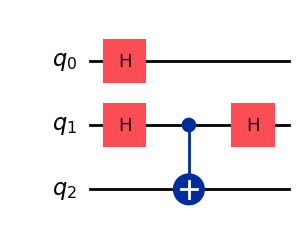

In [4]:

# fancy plot with matplotlib
circ.draw('mpl')

### The Quantum Gates in Cirq
We can access the unitary matrix of the gates in qiskit, such as the X-rotation gate $\exp(-iX\theta/2)$. We can also customize our own gates for simulation purpose.

Usually we want to use the built-in gates in qiskit which are compatible with many of the built-in qiskit functions, e.g. in certain optimizations.

You can find the list of built-in gates in the qiskit documentation `qiskit.circuit.library`.

In [5]:


# Hadamard gate
print('Hadamard gate:')
print(qiskit.circuit.library.HGate().to_matrix().real)

# Can access the gate for X-rotation
print('X-rotation:')
print(qiskit.circuit.library.RXGate(np.pi).to_matrix())

# for X**p gate
print('X power:')
print((qiskit.circuit.library.XGate()**0.5).to_matrix())

# two qubit CNOT gate
print('CNOT:')
print(qiskit.circuit.library.CXGate().to_matrix().real)

Hadamard gate:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
X-rotation:
[[6.123234e-17+0.j 0.000000e+00-1.j]
 [0.000000e+00-1.j 6.123234e-17+0.j]]
X power:
[[0.5+0.5j 0.5-0.5j]
 [0.5-0.5j 0.5+0.5j]]
CNOT:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


Qiskit allows for general single-qubit rotation such as the following


$$
U(\theta,\phi,\lambda) = \left[\begin{matrix} \cos\left(\frac{\theta}{2}\right) & -e^{i\lambda} \sin\left(\frac{\theta}{2}\right) \\ e^{i\phi}\sin\left(\frac{\theta}{2}\right) & e^{i(\phi+\lambda)}\cos\left(\frac{\theta}{2}\right)
\end{matrix}\right]
$$

[[ 0.70710678+0.j         -0.65328148-0.27059805j]
 [ 0.5       +0.5j         0.27059805+0.65328148j]]


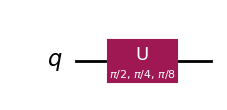

In [6]:
circ = qiskit.QuantumCircuit(1)
circ.u(np.pi/2,np.pi/4,np.pi/8,0)
print((qiskit.circuit.library.UGate(np.pi/2,np.pi/4,np.pi/8)).to_matrix())

circ.draw('mpl')

__WARNING!__

In contrast to the convention that you might be used to qiskit encodes the qubit from right to left, e.g. if $q_0 = \ket{1}$ and $q_1 = \ket{0}$ the 2-qubit state is represented as $\ket{01}$, and therefore also the tensor product is reversed, e.g. $CX$ would be represented as $X_1 \otimes I_0$, resulting in the above matrix representation.

### Hands-on coding

Can you write a function that returns the GHZ circuit on L qubits?


$$
\ket{\psi} = \frac{1}{\sqrt{2}}\left(\ket{00\cdots 0}+\ket{11\cdots 0}\right)
$$

In [7]:
def GHZ(num_qubits):
    qc = qiskit.QuantumCircuit(num_qubits)
    qc.h(0)
    
    for i in range(1, num_qubits):
        qc.cx(0, i)
    
    return qc



print(GHZ(5))

     ┌───┐                    
q_0: ┤ H ├──■────■────■────■──
     └───┘┌─┴─┐  │    │    │  
q_1: ─────┤ X ├──┼────┼────┼──
          └───┘┌─┴─┐  │    │  
q_2: ──────────┤ X ├──┼────┼──
               └───┘┌─┴─┐  │  
q_3: ───────────────┤ X ├──┼──
                    └───┘┌─┴─┐
q_4: ────────────────────┤ X ├
                         └───┘


### Simulating the Circuit
Qiskit provides handy simulator methods for quantum circuits. If you are using your laptop, you will be performing classical simulation. From __simulations__ we can get access to the full wavefunction that is constructed and modified by the quantum circuit.

However, if you are using a real quantum processor the wavefunciton is not accessible and you have to draw samples instead. More on that will follow later.

Qiskit has many options to simulate a circuit. Here we will restrict ourself to the `AerSimulator()`, which can be used for both simulating and sampling.

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2, 2, 2))


<IPython.core.display.Latex object>

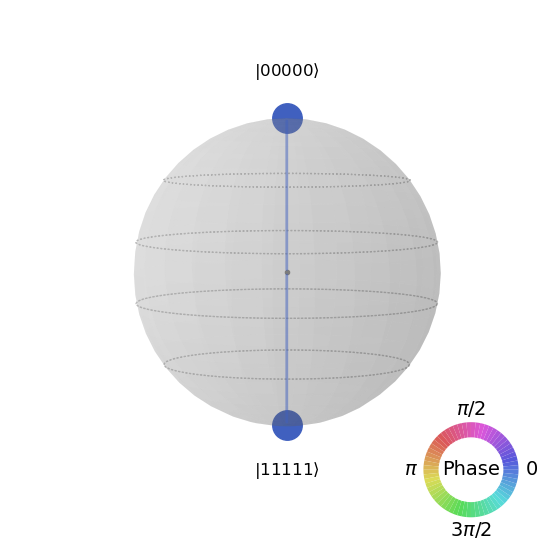

In [8]:
L = 5

# initialize the simulator in the "statevector" mode to simulate full wave function
sim = AerSimulator(method="statevector")

circ = GHZ(L)
circ.save_statevector()  # save statevector at the end of the circuit
state = sim.run(circ).result().get_statevector()

print(state)

# draw using latex
display(state.draw('latex'))

# draw on Bloch sphere
display(state.draw('qsphere'))


next we want to compute expectation values of local operators

In [14]:
# from qiskit.op import Z

In [16]:
Z = Pauli('Z')
# Expectation value computed from state vector
print("Exact Expectation:")
print(f"<Z> on qubit 1 is {state.expectation_value(Z, [1])}")
print(f"<ZZ> on qubit 1 and 2 is {state.expectation_value(Z^Z, [1, 2])}")

Exact Expectation:
<Z> on qubit 1 is 2.220446049250313e-16
<ZZ> on qubit 1 and 2 is 1.0


### Measurements on a circuit

On real devices we cannot simulate the full wavefunction but instead have to __measure__/ __sample__. 
In Qiskit we can mimic this by adding measurements which output the result to a classical channel.

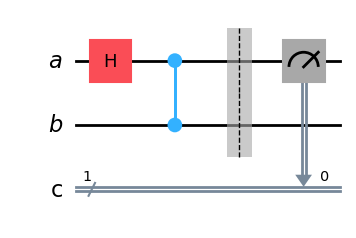

In [20]:
# define quantum and classical channels
a = qiskit.QuantumRegister(1, name = 'a')
b = qiskit.QuantumRegister(1, name = 'b')
c = qiskit.ClassicalRegister(1, name = 'c') # classical register to store the measurement outcome
circ = qiskit.QuantumCircuit(a, b, c) 
# alternative: qiskit.QuantumCircuit(2, 1) for 2 qubits and 1 classical channel


circ.h(a)
circ.cz(a, b)
circ.barrier() # visual barrier
circ.measure(a, c)  # measure qubit a and store the result in c

circ.draw('mpl')

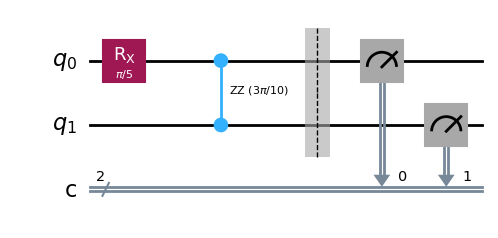

In [26]:
# Alternatively, we can shorten the codes using default namings.

circ = qiskit.QuantumCircuit(2,2)
circ.rx(0.2*np.pi,0)
circ.rzz(0.3*np.pi, 0, 1)
circ.barrier()
circ.measure(range(2),range(2)) # Measure the Quantum bits and store the result in the Classical bits
circ.draw('mpl')

In [32]:
circ = qiskit.QuantumCircuit(2,2)
circ.rx(0.2*np.pi,0)
circ.rzz(0.3*np.pi, 0, 1)
circ.barrier()
# circ.measure(range(2),range(2)) # Measure the Quantum bits and store the result in the Classical bits


circ.save_statevector()  # save statevector at the end of the circuit
sim = AerSimulator(method="statevector")
state = sim.run(circ).result().get_statevector()
print(state)
# draw using latex
display(state.draw('latex'))


Statevector([0.84739756-0.43177062j, 0.14029078-0.27533616j,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2))


<IPython.core.display.Latex object>

{'01': 11, '00': 89}


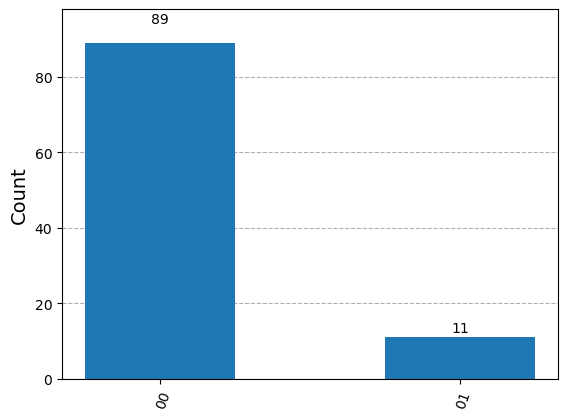

In [22]:
# run the circuit above via Aer

sim = AerSimulator()

N_shots = 100  # number of measurements

result = sim.run(circ, shots=N_shots).result()
counts = result.get_counts(circ)
print(counts)

plot_histogram(counts)

### Noise

In closed system, the quantum state is always pure. However this is not true in real world. The system will interact with the environment and become noisy.

Noise in the quantum system is in general realized by some __quantum channel__. Quantum channels map density matrix to another density matrix of the quantum system, i.e. the quantum states are generally mixed.

Noise can be included in Qiskit simulations in many ways. Let us consider an example here, and you will get to choose your favorite approach in later exercises.

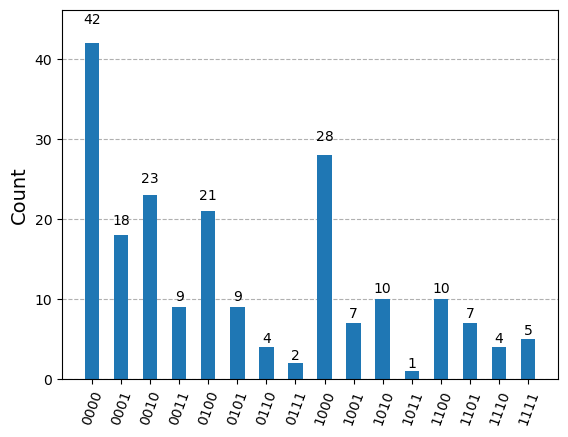

In [33]:

noisy_circ = qiskit.QuantumCircuit(4)
noisy_circ.measure_all() # trivial circuit, just measure

noise = NoiseModel()
# initialize bitflip error with a certain probability
p_error = 0.3
bit_flip_error = pauli_error([(Pauli('X'), p_error), (Pauli('I'), 1-p_error)])

noise.add_all_qubit_quantum_error(bit_flip_error, ['measure'])

simulator = AerSimulator(noise_model = noise)
result = simulator.run(noisy_circ, shots=200).result().get_counts(noisy_circ)
plot_histogram(result)


**Question:** How do the heights relate to the number of 1's in the bitstrings?

We can also add noise to the quantum operations.

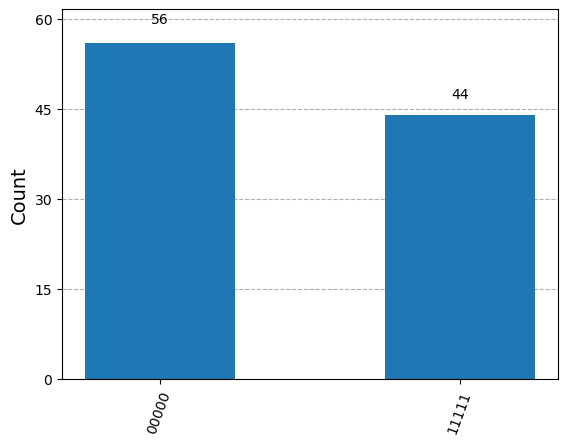

In [38]:

circ = GHZ(5)
circ.measure_all()

# Noiseless experiment
simulator = AerSimulator()
result = simulator.run(circ, shots = 100).result().get_counts(circ)
plot_histogram(result)

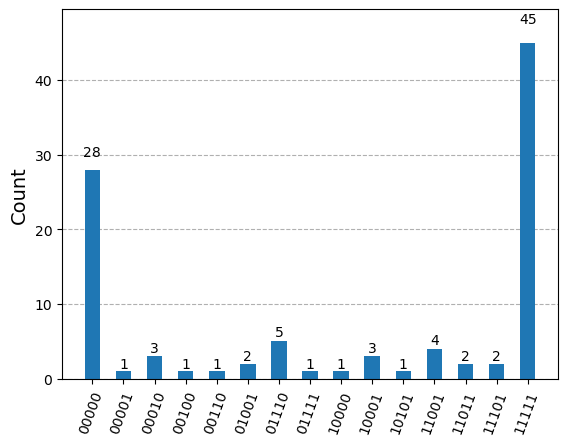

In [39]:
# Noisy experiment, where CNOTs are noisy
noise = NoiseModel()
error =  depolarizing_error(param = 0.1, num_qubits = 2)
noise.add_all_qubit_quantum_error(error, ['cx'])

simulator = AerSimulator(noise_model = noise)
result = simulator.run(circ, shots = 100).result().get_counts(circ)
plot_histogram(result)

Exercise 8: When you do a measurement on a quantum computer, you will only measure $|0\rangle$ or $|1\rangle$ (eigenstates of $Z$ or $\mathbb{I}$ ), and hence their probabilities. However, this information is not enough to get $\left\langle\hat{\sigma}_x\right\rangle$ and $\left\langle\hat{\sigma}_y\right\rangle$. We need to instead measure $|0\rangle$ and $|1\rangle$ in different basis. Verify the following identities
$$
X=H Z H, \quad Y=S H Z H S^{\dagger}
$$

You can look up the definition of the phase gate $S$ in Qiskit. Use Eq. (4.8) to construct Qiskit circuits to measure $\left\langle\hat{\sigma}_x\right\rangle,\left\langle\hat{\sigma}_y\right\rangle$ and $\left\langle\hat{\sigma}_z\right\rangle$.

In [40]:
qiskit.circuit.library.HGate().to_matrix()

array([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]])

In [41]:
qiskit.circuit.library.SGate().to_matrix()

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j]])

In [124]:
def get_sz(qc_z, num_shots):
    # Measure in the Z-basis (computational basis)
    qc_z.measure(0, 0)

    # Execute the circuit
    simulator = AerSimulator()
    counts_z = simulator.run(qc_z, shots = num_shots).result().get_counts(qc_z)
    # Plot the histogram
    # plot_histogram(counts_z)
    return -(counts_z['1']-counts_z['0'])/num_shots

def get_sx(qc_x, num_shots):
    # Measure in the Z-basis (computational basis)
    qc_x.h(0)
    # Measure in the computational basis
    qc_x.measure(0, 0)
    # Execute the circuit
    simulator = AerSimulator()
    counts_x = simulator.run(qc_x, shots = num_shots).result().get_counts(qc_x)
    return -(counts_x['1']-counts_x['0'])/num_shots

def get_sy(qc_y, num_shots):
    qc_y.sdg(0)
    qc_y.h(0)
    # Measure in the computational basis
    qc_y.measure(0, 0)
    # Execute the circuit
    simulator = AerSimulator()
    counts_y = simulator.run(qc_y, shots = num_shots).result().get_counts(qc_y)
    return -(counts_y['1']-counts_y['0'])/num_shots



## $\left\langle\hat{\sigma}_z\right\rangle$

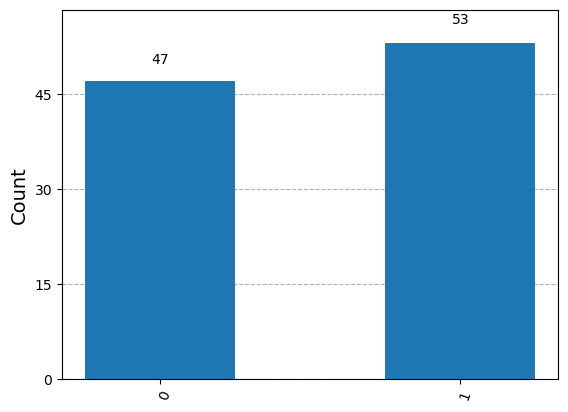

In [49]:
qc_z = qiskit.QuantumCircuit(1, 1)

# Prepare your quantum state here
# For example, applying a Hadamard gate
qc_z.h(0)

# Measure in the Z-basis (computational basis)
qc_z.measure(0, 0)

# Execute the circuit
simulator = AerSimulator()
counts_z = simulator.run(qc_z, shots = 100).result().get_counts(qc_z)
# Plot the histogram
plot_histogram(counts_z)

## $\left\langle\hat{\sigma}_x\right\rangle$

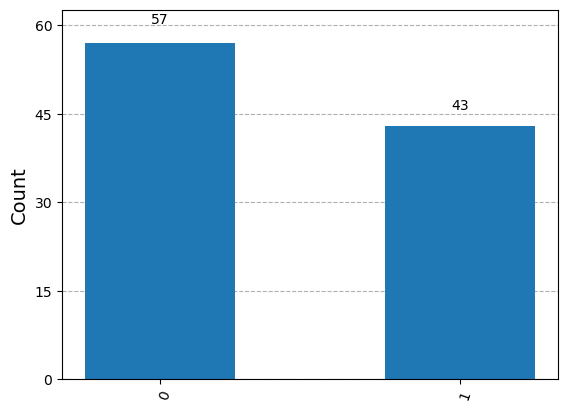

In [46]:
qc_x = qiskit.QuantumCircuit(1, 1)

# Prepare your quantum state here
# For example, applying a Hadamard gate
# qc_x.h(0)

# Measure in the Z-basis (computational basis)
qc_x.h(0)

# Measure in the computational basis
qc_x.measure(0, 0)

# Execute the circuit
simulator = AerSimulator()
counts_x = simulator.run(qc_x, shots = 100).result().get_counts(qc_x)
# Plot the histogram
plot_histogram(counts_x)

In [74]:
(counts_y['1']-counts_y['0'])/100

0.52

## $\left\langle\hat{\sigma}_y\right\rangle$

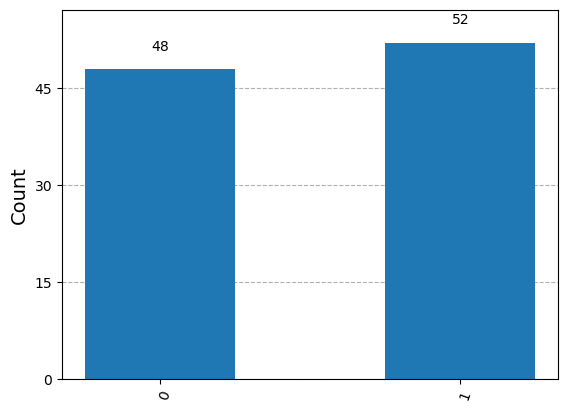

In [47]:
qc_y = qiskit.QuantumCircuit(1, 1)

# Prepare your quantum state here
# For example, applying a Hadamard gate
# qc_x.h(0)

# Measure in the Z-basis (computational basis)
qc_y.sdg(0)
qc_y.h(0)

# Measure in the computational basis
qc_y.measure(0, 0)

# Execute the circuit
simulator = AerSimulator()
counts_y = simulator.run(qc_y, shots = 100).result().get_counts(qc_y)

# Plot the histogram
plot_histogram(counts_y)

Exercise 9: Try the single-qubit tomograph method in Eq
$$
    c_i=\frac{1}{2}\left\langle\hat{\sigma}_i\right\rangle=\frac{1}{2} \operatorname{Tr}\left(\hat{\sigma}_i \rho\right) \text {, }
$$
 measure all the coefficients $c_i$ from finite sampling, reconstruct the single-qubit density matrix for $\left(|0\rangle+e^{i \pi / 4}|1\rangle\right) / \sqrt{2}=T H|0\rangle$ ( $\mathrm{T}$ is a non-Clifford gate!). How do you extract the qubit state from the measured density matrix? Benchmark your result with the Qiskit builtin function StateTomography().

In [82]:
def state9():
    qc = qiskit.QuantumCircuit(1, 1)
    qc.h(0)
    qc.t(0)
    return qc



In [115]:
nq = 1
# qc_ghz = qiskit.QuantumCircuit(nq)

qc_ghz = state9()


# QST Experiment
qstexp1 = StateTomography(qc_ghz)
backend = AerSimulator.from_backend(FakePerth())
qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)

state_result = qstdata1.analysis_results("state")
print(state_result.value)

AnalysisResult
- name: state
- value: DensityMatrix([[0.50585938+0.j        , 0.33398438-0.36132812j],
               [0.33398438+0.36132812j, 0.49414063+0.j        ]],
              dims=(2,))
- quality: unknown
- extra: <9 items>
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: state_fidelity
- value: 0.9916601837937719
- quality: unknown
- extra: <9 items>
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: positive
- value: True
- quality: unknown
- extra: <9 items>
- device_components: ['Q0']
- verified: False
DensityMatrix([[0.50585938+0.j        , 0.33398438-0.36132812j],
               [0.33398438+0.36132812j, 0.49414063+0.j        ]],
              dims=(2,))


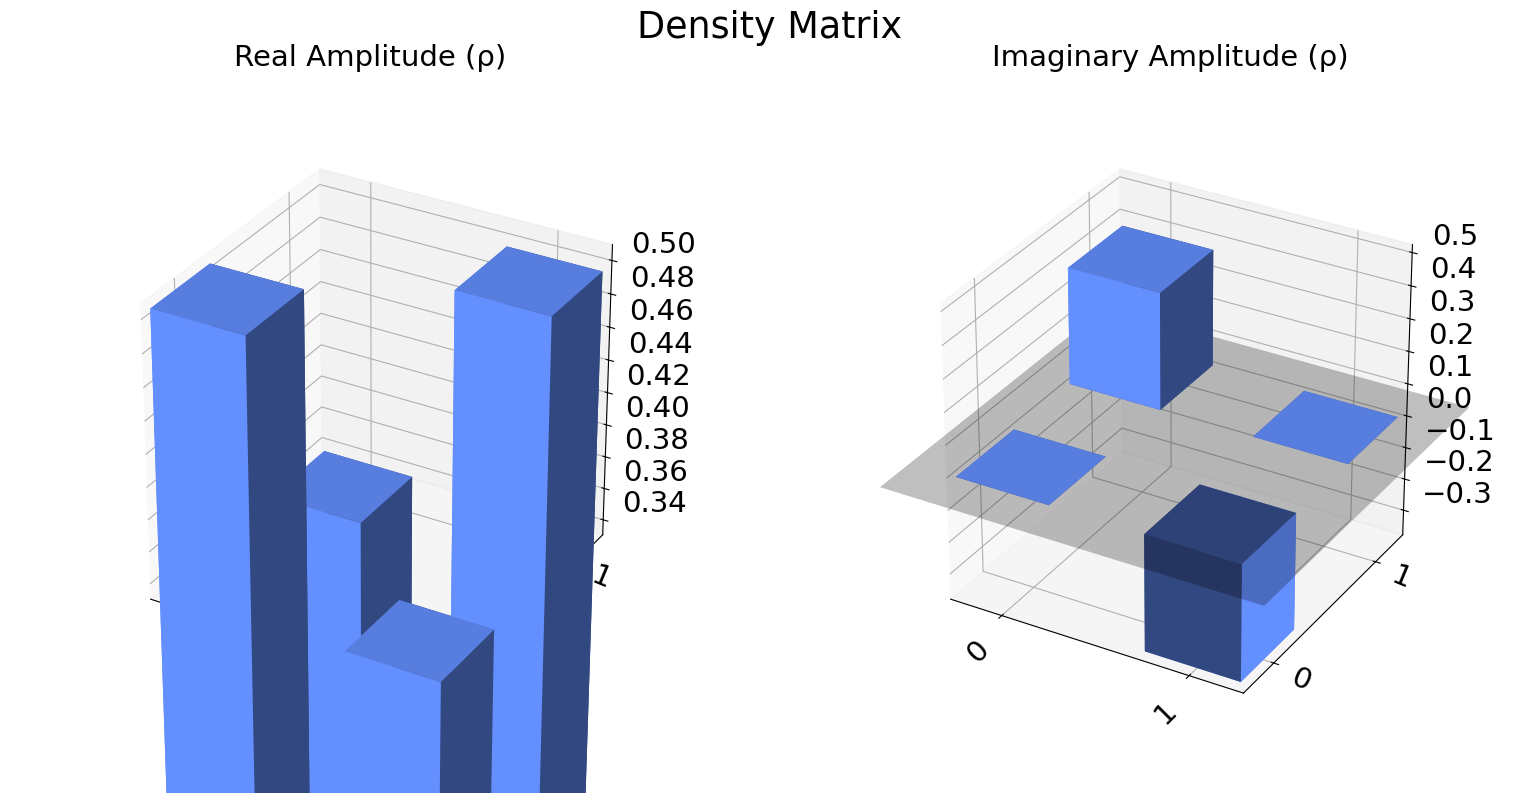

In [116]:
from qiskit.visualization import plot_state_city
plot_state_city(qstdata1.analysis_results("state").value, title='Density Matrix')



In [117]:
fid_result = qstdata1.analysis_results("state_fidelity")
print("State Fidelity = {:.5f}".format(fid_result.value))

State Fidelity = 0.99166


[[0.507+0.j    0.341-0.365j]
 [0.341+0.365j 0.493+0.j   ]]


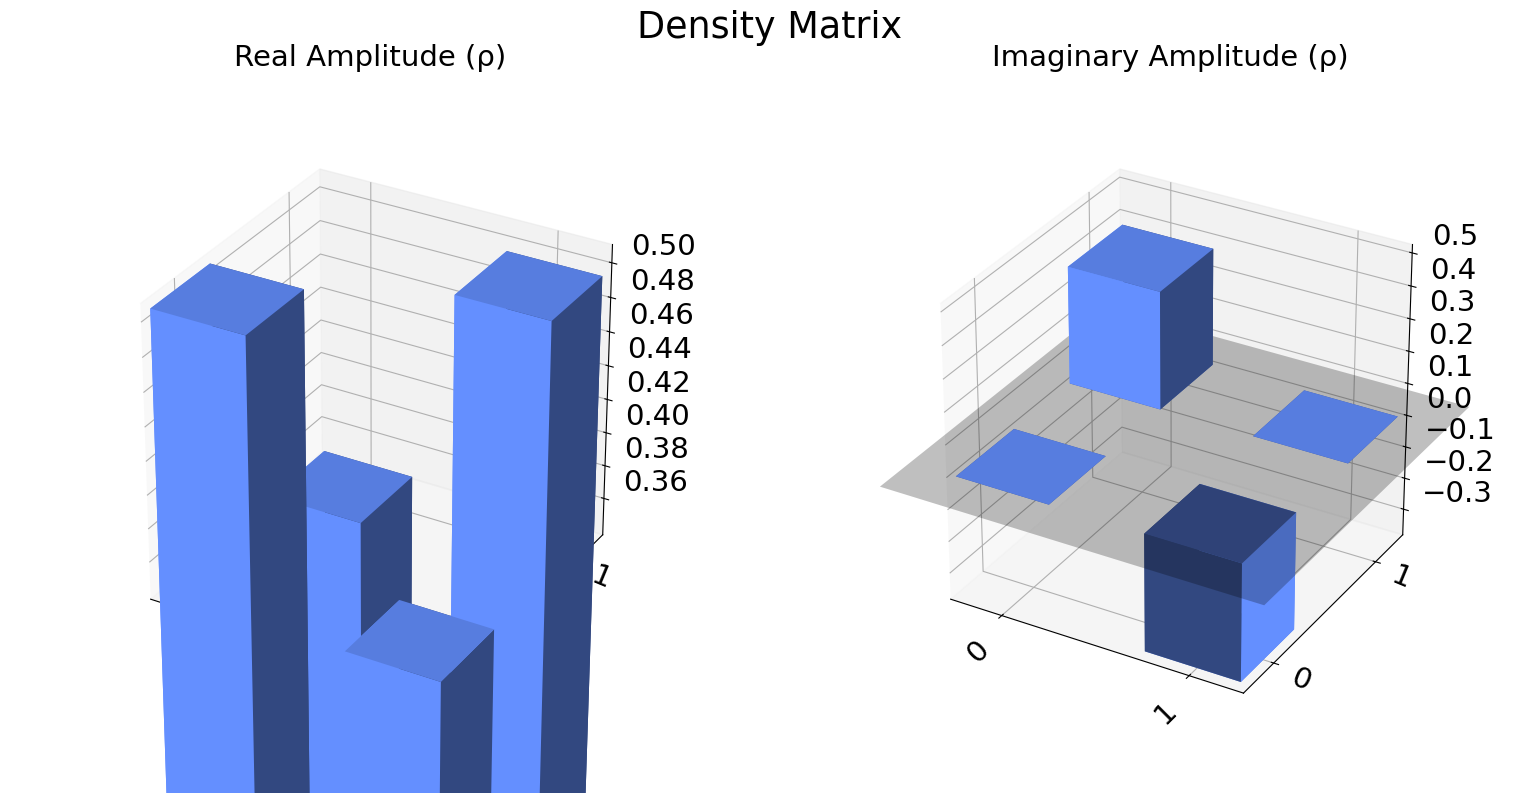

In [125]:
qc_ghz = state9()
sz =  0.5*get_sz(qc_ghz, num_shots=1000)
qc_ghz = state9()
sy =  0.5*get_sy(qc_ghz, num_shots=1000)
qc_ghz = state9()
sx =  0.5*get_sx(qc_ghz, num_shots=1000)

# qiskit.circuit.library.XGate()**0.5).to_matrix()
dd = ((0.5)*Pauli('I').to_matrix() + 
     sz*Pauli('Z').to_matrix() + sy*Pauli('Y').to_matrix() + sx*Pauli('X').to_matrix() )
print(dd)
ddmat = qiskit.quantum_info.DensityMatrix(dd)
plot_state_city(ddmat, title='Density Matrix')


(0.507+0j)

Statevector([0.70710678+0.j , 0.5       +0.5j],
            dims=(2,))


<IPython.core.display.Latex object>

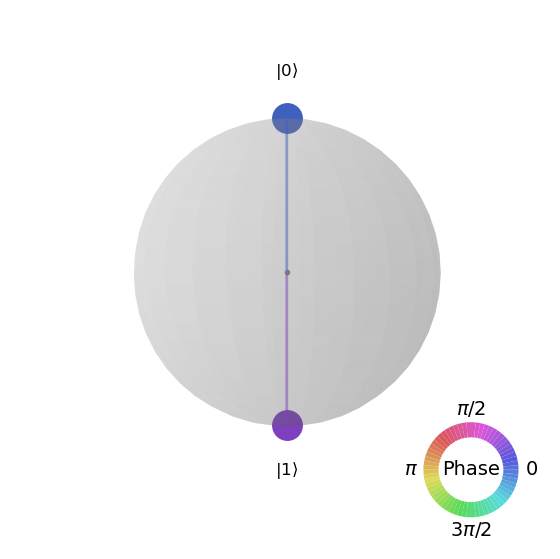

In [97]:
qc = qiskit.QuantumCircuit(1, 1)
qc.h(0)
qc.t(0)

qc.save_statevector()  # save statevector at the end of the circuit
state = sim.run(qc).result().get_statevector()

print(state)

# draw using latex
display(state.draw('latex'))

# draw on Bloch sphere
display(state.draw('qsphere'))


Exercise 10: Use the same set of parameters as in Exercise 5(a), reconstruct the oscillating qubit state by tomography (either your custom one or Qiskit built-in) for $t \in[0,2]$ and compare your result with Eq. (4.4) (both the complex coefficients $\alpha(t)$ and $\beta(t))$, do they agree? (Note that the states are equivalent up to an overall phase, you can set $\beta$ to be real and compare $\alpha$ or vice versa).

In [60]:
def time_evolve(circ, t, dt, w, w0, w1):
    """
    Apply the time-evolution operator U(t) using Trotterization.
    Arguments:
    - circ: QuantumCircuit, the circuit to which the evolution is applied
    - t: float, total time of the evolution
    - dt: float, time step for the Trotterization
    - w: float, frequency of the external field
    - w0: float, system frequency
    - w1: float, strength of the driving field
    """
    N = int(t / dt)  # number of time steps
    for n in range(N):
        circ.rz(w0 * dt, 0)  # Rotation around Z-axis
        circ.rx(-2.0 * w1 * dt * np.cos(w * dt * n), 0)  # Rotation around X-axis, modulated by cos(w*dt)
    
    return circ

def do_exp_10(t, w = 25.0, w0 = 25.0, w1 = 2.0, n_shots=80000, dt = 0.03):
    """
    dt -- time step
    w  -- external frequency
    w0 -- system frequency
    w1 -- driving field strength
    """
    # Create a new quantum circuit with one qubit
    qc = qiskit.QuantumCircuit(1)
    
    # Time evolve the circuit
    qc = time_evolve(qc, t, dt, w, w0, w1)
    
    qstexp1 = StateTomography(qc)
    backend = AerSimulator.from_backend(FakePerth())
    qstdata1 = qstexp1.run(backend, seed_simulation=n_shots).block_for_results()
    dmat = qstdata1.analysis_results("state").value
    dmatMM = dmat.to_operator().to_matrix()
    print(dmatMM)
    a = dmatMM[0, 0]**0.5
    b= dmatMM[1, 1]**0.5
    phase = dmatMM[1, 0]/b/a
    print(np.abs(phase))
    return dmatMM[0, 0], dmatMM[1, 1], a, b, phase
    
    # # Add measurement
    qc.measure_all()
    
    # Simulate the circuit using the recommended API
    simulator = Aer.get_backend('statevector_simulator')
    # simulator = AerSimulator().get_backend('qasm_simulator')
    transpiled_circuit = qiskit.transpile(qc, simulator)
    job = simulator.run(transpiled_circuit, shots=n_shots)
    result = job.result()
    counts = result.get_counts()
    
    if '1' in counts.keys():
        return counts["1"] / n_shots
    else:
       return 0

In [61]:
for t in [0.5]:
    _, _, a, b, phi = do_exp_10(t, w, w0, w1)
a, b, phi

[[0.77929688+0.j         0.37792969-0.09179688j]
 [0.37792969+0.09179688j 0.22070313+0.j        ]]
0.937783898800736


((0.882777930739096+0j),
 (0.4697905118241542+0j),
 (0.9112872620732156+0.22134626003845548j))

In [28]:
ts = np.linspace(0, 3, 100)
alphas = []
betas = []
phases = []
rho0s = []
rho1s = []

w = 25.0
w0 = 25.0
w1 = 2.0
Delta = w - w0
Omega = (w1**2.0 + Delta**2.0)**0.5

alphas_th = np.exp( 1j*w*ts*0.5 )*(np.cos(Omega*ts*0.5) - 1j* Delta * np.sin( Omega*ts*0.5)/Omega)
betas_th = np.exp( -1j*w*ts*0.5 )*( - 1j* w1 * np.sin( Omega*ts*0.5)/Omega)

alphas_th = alphas_th*np.exp(- 1j* np.angle(alphas_th))
betas_th = betas_th*np.exp(- 1j* np.angle(alphas_th))

betas_thabs = np.abs(betas_th)
phases_th = betas_th/betas_thabs

for t in tqdm(ts):
    rho0, rho1, a, b, phase = do_exp_10(t, w, w0, w1)
    alphas.append(a)
    betas.append(b)
    phases.append(phase)
    rho0s.append(rho0)
    rho1s.append(rho1)

/tmp/ipykernel_222742/1293050017.py:21: RuntimeWarning: invalid value encountered in divide
  phases_th = betas_th/betas_thabs
100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


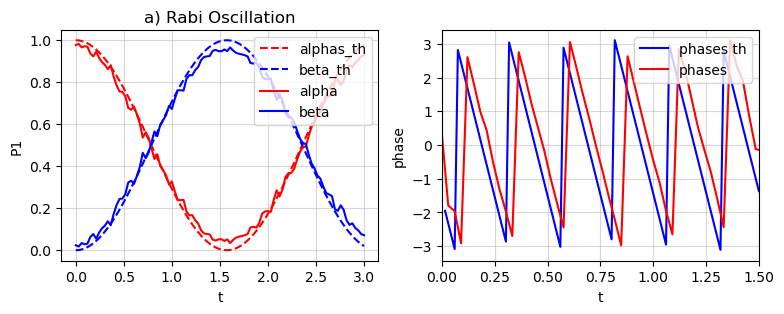

In [74]:
fig, (ax_a, bx) = plt.subplots(1, 2, figsize=(9,3))
# ax_a.plot(ts, np.real(alphas), "blue")
# ax_a.plot(ts, np.real(alphas_th), '--', color="red", label='alphas_th abs')
# ax_a.plot(ts, betas_thabs, '--', color="blue", label='betas_th abs')

# ax_a.plot(ts, np.abs(alphas), 'o', color="red", label='alphas')
# ax_a.plot(ts, np.abs(betas),'-', color="blue", label='betas')

ax_a.plot(ts, np.abs(alphas_th)**2.0, '--', color="red", label='alphas_th')
ax_a.plot(ts, np.abs(betas_th)**2.0 , '--', color="blue", label='beta_th')
ax_a.plot(ts, np.real(np.array(rho0s)), '-', color="red", label='alpha')
ax_a.plot(ts, np.real(np.array(rho1s)), '-', color="blue", label='beta')


ax_a.grid(alpha=0.5)
ax_a.set_title("a) Rabi Oscillation")
ax_a.set_xlabel("t")
ax_a.set_ylabel("P1")
ax_a.legend(loc="upper right")


bx.plot(ts*0.5, np.angle(phases_th),'-', color="blue", label='phases th')
bx.plot(ts, -np.angle(phases),'-', color="red", label='phases')
bx.set_xlim((0, 1.5))
bx.grid(alpha=0.5)
bx.set_xlabel("t")
bx.set_ylabel("phase")
bx.legend(loc="upper right")

plt.show()

In [75]:
# ts = np.linspace(0, 10, 800)


# alphas_th = np.exp( 1j*w*ts*0.5 )*(np.cos(Omega*ts*0.5) - 1j* Delta * np.sin( Omega*ts*0.5)/Omega)
# betas_th = np.exp( -1j*w*ts*0.5 )*( - 1j* w1 * np.sin( Omega*ts*0.5)/Omega)

# alphas_th = alphas_th*np.exp(- 1j* np.angle(alphas_th))
# betas_th = betas_th*np.exp(- 1j* np.angle(alphas_th))


# fig, (ax_a) = plt.subplots(1, 1, figsize=(9,3))
# # ax_a.plot(ts, np.real(alphas), "blue")
# ax_a.plot(ts, np.real(alphas_th), '--', color="red", label='alphas_th')
# ax_a.plot(ts, np.real(betas_th), '--', color="blue", label='betas_th re')
# ax_a.plot(ts, np.imag(betas_th), '-.', color="blue", label='betas_th im')

# ax_a.grid(alpha=0.5)
# ax_a.set_title("a) Rabi Oscillation")
# ax_a.set_xlabel("t")
# ax_a.set_ylabel("P1")
# ax_a.legend(loc="upper right")
# # add_text(ax_a, "w0=25.0\nw=25.5\nw1=2.0", ts, Ps, 0.65, 0.8)

# # Ps_b1 = [do_exp_5a(t) for t in ts]
# # Ps_b1 = [do_exp_5a(t=np.pi/w1, w1=w1) for t in ts]

# plt.show()

## 4.4

Exercise 11: Let us consider the trial state of the form
$$
|\psi(a, b)\rangle=\exp \left(i a\left(\hat{\sigma}_z^1+\hat{\sigma}_z^2\right)\right) \exp \left(i b\left(\hat{\sigma}_x^1 \hat{\sigma}_z^2+\hat{\sigma}_z^1 \hat{\sigma}_x^2\right)\right)|00\rangle
$$
where $a, b$ are some real parameters. Construct a parametrized circuit for this ansatz.

In [78]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

In [79]:
def state44(a, b):
    qc = qiskit.QuantumCircuit(2, 2)
    # Apply exp(i a (sigma_z^1 + sigma_z^2))
    qc.rz(2 * a, 0)  # Rz(theta) = exp(-i * theta/2 * Z)
    qc.rz(2 * a, 1)

    # Apply exp(i b (sigma_x^1 sigma_z^2 + sigma_z^1 sigma_x^2))
    # This part requires a combination of CX gates and rotations.

    # First part: apply exp(i b sigma_x^1 sigma_z^2)
    qc.cx(1, 0)
    qc.rx(2 * b, 0)
    qc.cx(1, 0)

    # Second part: apply exp(i b sigma_z^1 sigma_x^2)
    qc.cx(0, 1)
    qc.rx(2 * b, 1)
    qc.cx(0, 1)

    return qc

a = Parameter('a')
b = Parameter('b')
state44(a, b)


## 2

$$
U(t)=e^{-i \hat{H} t}=\left(e^{-i \hat{H} d t}\right)^{t / d t}=\left(e^{\hat{A}+\hat{B}}\right)^{t / d t},
$$
with $\hat{A}=i d t \frac{g}{2} \sum_i X_i$ and $\hat{B}=i d t \frac{1}{2} \sum_{\langle i, j\rangle} Z_i Z_j$.

$$
e^{\hat{A}+\hat{B}} \approx e^A e^B
$$

$$
e^{i \delta t / 2 \sum_{\langle i, j\rangle} Z_i Z_j}=\prod_{i=0}^{N / 2-1} e^{i \delta t / 2 Z_{2 i} Z_{2 i+1}} \prod_{i=0}^{N / 2-2} e^{i \delta t / 2 Z_{2 i+1} Z_{2 i+2}}
$$

$$
R X(\theta)=\exp \left(-i \frac{\theta}{2} X\right)
$$

$$
R_{Z Z}(\theta)=\exp \left(-i \frac{\theta}{2} Z \otimes Z\right)
$$

In [48]:
def evolve_basic(circ, t, dt, g):
    """
    Apply the time-evolution operator U(t) using first order Trotterization  
    Arguments:
    - circ: QuantumCircuit, the circuit to which the evolution is applied
    - t: float, total time of the evolution
    - dt: float, time step for the Trotterization
    - g: float, model parameter
    """
    N = int(t / dt)  # number of time steps
    num_q = circ.num_qubits
    
    for n in range(N):
        for q in range(num_q):
            circ.rx(- g * dt, q)  

        # Apply the RZZ gates to even bonds
        for i in range(0, num_q - 1, 2):
            circ.rzz(- dt, i, i + 1)

        # Apply the RZZ gates to odd bonds
        for i in range(1, num_q - 2, 2):
            circ.rzz(- dt, i, i + 1)

    return circ

def evolve_symmetric(circ,  t, dt, g):
    """
    Apply the time-evolution operator U(t) using  second order Trotterization  
    Arguments:
    - circ: QuantumCircuit, the circuit to which the evolution is applied
    - t: float, total time of the evolution
    - dt: float, time step for the Trotterization
    - g: float, model parameter
    """
    N = int(t / dt)  # number of time steps
    num_q = circ.num_qubits
    for n in range(N):
        for q in range(num_q):
            circ.rx(- 0.5* g * dt, q)  

        # Apply the RZZ gates to even bonds
        for i in range(0, num_q - 1, 2):
            circ.rzz(- dt, i, i + 1)

        # Apply the RZZ gates to odd bonds
        for i in range(1, num_q - 2, 2):
            circ.rzz(- dt, i, i + 1)

        for q in range(num_q):
            circ.rx(- 0.5* g * dt, q)  


    return circ


def digit_sum(n):
    num_str = str(n)
    sum = 0
    for i in range(0, len(num_str)):
        sum += int(num_str[i])
    return sum

def TFIM_1(t, evolve_method, num_q=10, g = 1.0, n_shots=400, dt = 0.03):
    """
    dt -- time step
    w  -- external frequency
    w0 -- system frequency
    w1 -- driving field strength
    """
    # Create a new quantum circuit with one qubit
    qc = qiskit.QuantumCircuit(num_q)
    
    # Time evolve the circuit
    # qc = evolve_basic(qc, t, dt, g)
    qc = evolve_method(qc, t, dt, g)

    qc.measure_all()
    
    # Simulate the circuit using the recommended API
    simulator = Aer.get_backend('statevector_simulator')
    # simulator = AerSimulator().get_backend('qasm_simulator')
    transpiled_circuit = qiskit.transpile(qc, simulator)
    job = simulator.run(transpiled_circuit, shots=n_shots)
    result = job.result()
    counts = result.get_counts()

    r1=list(counts.keys())
    r2=list(counts.values())
    M=0
    for j in range(0,len(r1)):
        M=M+2.0*(0.5- digit_sum(r1[j])/float(num_q) )*r2[j] /n_shots
    return M
    

In [49]:
TFIM_1( 0, evolve_basic, num_q=10, g = 2.0, n_shots=400, dt = 0.03)


1.0

In [50]:
TFIM_1(3.0,evolve_symmetric, num_q=10, g = 2.0, n_shots=400, dt = 0.03)


0.14149999999999996

In [115]:
ts = np.linspace(0, 3, 100)
Ms_basic = []
Ms_symm = []

for t in tqdm(ts):
    M = TFIM_1(t, evolve_basic, num_q=10, g = 2.0, n_shots=200, dt = 0.02)
    Ms_basic.append(M)
    M = TFIM_1(t, evolve_symmetric, num_q=10, g = 2.0, n_shots=200, dt = 0.02)
    Ms_symm.append(M)
Ms_basic = np.array(Ms_basic)
Ms_symm = np.array(Ms_symm)


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


In [116]:
import exact_diagonalization as ed

In [117]:
magn_th = ed.magn_exact_diagonalization(N=10, g=2.0, t=3.0, Npoints=100)

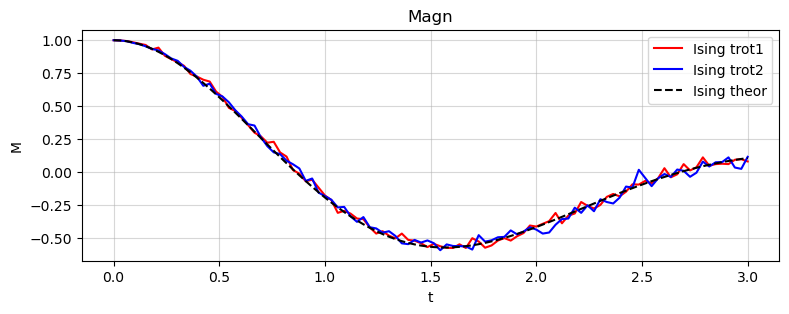

In [119]:
fig, ax_a = plt.subplots(1, 1, figsize=(9,3))

ax_a.plot(ts, Ms_basic, '-', color="red", label='Ising trot1')
ax_a.plot(ts, Ms_symm, '-', color="blue", label='Ising trot2')
ax_a.plot(ts, magn_th, '--', color="black", label='Ising theor')
ax_a.grid(alpha=0.5)

ax_a.set_title("Magn")
ax_a.set_xlabel("t")
ax_a.set_ylabel("M")
ax_a.legend(loc="upper right")

plt.savefig('./report/pics/M.png',format='png', dpi=300,  bbox_inches='tight')
plt.show()

# 3

In [5]:
def evolve_basic(circ, t, dt, g):
    """
    Apply the time-evolution operator U(t) using first order Trotterization  
    Arguments:
    - circ: QuantumCircuit, the circuit to which the evolution is applied
    - t: float, total time of the evolution
    - dt: float, time step for the Trotterization
    - g: float, model parameter
    """
    N = int(t / dt)  # number of time steps
    num_q = circ.num_qubits
    
    for n in range(N):
        for q in range(num_q):
            circ.rx(- g * dt, q)  

        # Apply the RZZ gates to even bonds
        for i in range(0, num_q - 1, 2):
            circ.rzz(- dt, i, i + 1)

        # Apply the RZZ gates to odd bonds
        for i in range(1, num_q - 2, 2):
            circ.rzz(- dt, i, i + 1)

    return circ



def TFIM_2(t, evolve_method, num_q=10, g = 1.0, n_shots=400, dt = 0.03):
    """
    dt -- time step
    w  -- external frequency
    w0 -- system frequency
    w1 -- driving field strength
    """
    # Create a new quantum circuit with one qubit
    qc = qiskit.QuantumCircuit(num_q)
    
    GSup = qiskit.QuantumCircuit(num_q)
    GSdown = qiskit.QuantumCircuit(num_q)
    for qubit in range(num_q):
        GSdown.x(qubit)


    # Time evolve the circuit
    # qc = evolve_basic(qc, t, dt, g)
    qc = evolve_method(qc, t, dt, g)


    # Get the statevector simulator backend
    statevector_simulator = Aer.get_backend('statevector_simulator')

    # Simulate the first circuit
    result1 = statevector_simulator.run(GSup).result()
    statevectorGSup = result1.get_statevector()

    result1 = statevector_simulator.run(GSdown).result()
    statevectorGSdown = result1.get_statevector()


    result1 = statevector_simulator.run(qc).result()
    STATEvector = result1.get_statevector()

    
    l1 = np.abs(np.vdot(statevectorGSup, STATEvector))**2.0
    l2 = np.abs(np.vdot(statevectorGSdown, STATEvector))**2.0
    L = l1 + l2
    # print(num_q)
    return -np.log(1 if L == 0 else L)/num_q,  -np.log(1 if l1 == 0 else l1)/num_q, -np.log( 1 if l2 == 0 else l2 )/num_q
    



In [6]:
TFIM_2( 0.1, evolve_basic, num_q=10, g = 2.0, n_shots=400, dt = 0.003)


(0.00978952110501885, 0.00978952110501885, 4.629116410185003)

In [113]:
ts = np.linspace(0, 3, 100)
Ls = []
l1s = []
l2s = []
num_qs = [6, 8, 10, 12]
results = {}

for num_q in num_qs:
    Ls = []
    l1s = []
    l2s = []
    for t in tqdm(ts):
        L, l1, l2 = TFIM_2(t, evolve_basic, num_q=num_q, g = 2.0, n_shots=100, dt = 0.02)
        Ls.append(L)
        l1s.append(l1)
        l2s.append(l2)
    Ls = np.array(Ls)
    l1s = np.array(l1s)
    l2s = np.array(l2s)
    results[num_q] = [Ls, l1s, l2s]



100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


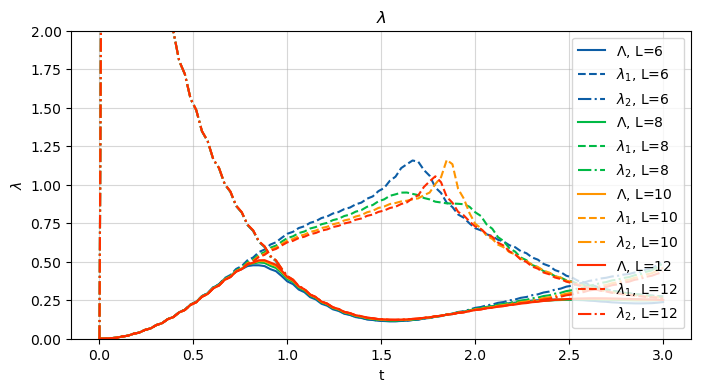

In [114]:
fig, ax_a = plt.subplots(1, 1, figsize=(8,4))
colors = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
# custom_cycler =  (cycler('color', ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']) ) #+ cycler('ls', ['-', '--', '-.', ':', '-', '--', ':'])
# ax_a.set_prop_cycle(custom_cycler)


for i, num_q in enumerate(num_qs):
    ax_a.plot(ts, results[num_q][0], '-',color = colors[i],  label=rf'$\Lambda$, L={num_q}')
    ax_a.plot(ts, results[num_q][1], '--',color = colors[i],  label=rf'$\lambda_1$, L={num_q}')
    ax_a.plot(ts, results[num_q][2], '-.',color = colors[i],  label=rf'$\lambda_2$, L={num_q}')

# ax_a.plot(ts, Ms_symm, '-', color="blue", label='Ising trot2')
# ax_a.plot(ts, magn_th, '--', color="black", label='Ising theor')
ax_a.grid(alpha=0.5)
ax_a.set_ylim((0, 2))
ax_a.set_title(r'$\lambda$')
ax_a.set_xlabel("t")
ax_a.set_ylabel(r'$\lambda$')
ax_a.legend(loc="upper right")

plt.savefig('./report/pics/lambda8a.png',format='png', dpi=300,  bbox_inches='tight')
plt.show()

In [107]:
ts = np.linspace(0, 4, 150)
Ls = []
l1s = []
l2s = []
gs = np.arange(0.5, 1.5, 0.25)
results = {}

for g in gs:
    Ls = []
    l1s = []
    l2s = []
    for t in tqdm(ts):
        L, l1, l2 = TFIM_2(t, evolve_basic, num_q=10, g = g, n_shots=100, dt = 0.02)
        Ls.append(L)
        l1s.append(l1)
        l2s.append(l2)
    Ls = np.array(Ls)
    l1s = np.array(l1s)
    l2s = np.array(l2s)
    results[g] = [Ls, l1s, l2s]



100%|██████████| 150/150 [00:07<00:00, 18.98it/s]


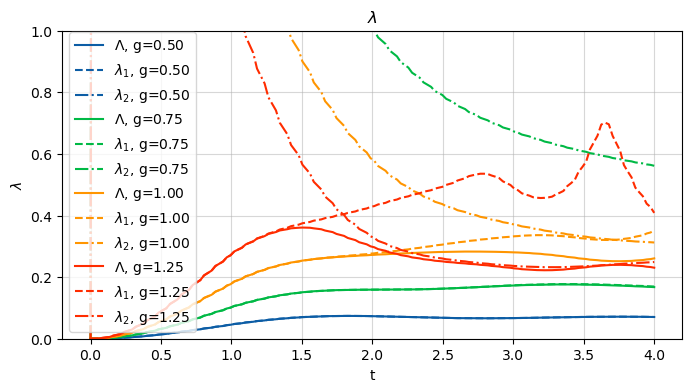

In [111]:
fig, ax_a = plt.subplots(1, 1, figsize=(8,4))
colors = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
# custom_cycler =  (cycler('color', ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']) ) #+ cycler('ls', ['-', '--', '-.', ':', '-', '--', ':'])
# ax_a.set_prop_cycle(custom_cycler)


for i, g in enumerate(gs):
    ax_a.plot(ts, results[g][0], '-',color = colors[i],     label=rf'$\Lambda$, g={g:.2f}')
    ax_a.plot(ts, results[g][1], '--',color = colors[i],  label=rf'$\lambda_1$, g={g:.2f}')
    ax_a.plot(ts, results[g][2], '-.',color = colors[i],  label=rf'$\lambda_2$, g={g:.2f}')

# ax_a.plot(ts, Ms_symm, '-', color="blue", label='Ising trot2')
# ax_a.plot(ts, magn_th, '--', color="black", label='Ising theor')
ax_a.grid(alpha=0.5)
ax_a.set_ylim((0, 1))
ax_a.set_title(r'$\lambda$')
ax_a.set_xlabel("t")
ax_a.set_ylabel(r'$\lambda$')
ax_a.legend(loc="best")

plt.savefig('./report/pics/lambda8b.png',format='png', dpi=300,  bbox_inches='tight')
plt.show()

In [123]:

def TFIM_3(t, evolve_method, num_q=10, g = 1.0, n_shots=400, dt = 0.03):
    """
    dt -- time step
    w  -- external frequency
    w0 -- system frequency
    w1 -- driving field strength
    """
    # Create a new quantum circuit with one qubit
    qc = qiskit.QuantumCircuit(num_q)
    
    GSup = qiskit.QuantumCircuit(num_q)
    GSdown = qiskit.QuantumCircuit(num_q)
    for qubit in range(num_q):
        GSdown.x(qubit)


    # Time evolve the circuit
    # qc = evolve_basic(qc, t, dt, g)
    qc = evolve_method(qc, t, dt, g)


    # Get the statevector simulator backend
    statevector_simulator = Aer.get_backend('statevector_simulator')

    # Simulate the first circuit
    result1 = statevector_simulator.run(GSup).result()
    statevectorGSup = result1.get_statevector()

    result1 = statevector_simulator.run(GSdown).result()
    statevectorGSdown = result1.get_statevector()


    result1 = statevector_simulator.run(qc).result()
    STATEvector = result1.get_statevector()

    
    l1 = np.abs(np.vdot(statevectorGSup, STATEvector))**2.0
    l2 = np.abs(np.vdot(statevectorGSdown, STATEvector))**2.0
    L = l1 + l2
    # print(num_q)
    # return -np.log(1 if L == 0 else L)/num_q,  -np.log(1 if l1 == 0 else l1)/num_q, -np.log( 1 if l2 == 0 else l2 )/num_q
    
    qc.measure_all()
    
    transpiled_circuit = qiskit.transpile(qc, statevector_simulator)
    job = statevector_simulator.run(transpiled_circuit, shots=n_shots)
    result = job.result()
    counts = result.get_counts()

    r1=list(counts.keys())
    r2=list(counts.values())
    M=0
    for j in range(0,len(r1)):
        M=M+2.0*(0.5- digit_sum(r1[j])/float(num_q) )*r2[j] /n_shots
    return -np.log(1 if L == 0 else L)/num_q, M
    

In [133]:
ts = np.linspace(0, 4, 100)
Ls = []
Ms = []

gs = np.arange(0.5, 2.0, 0.5)
results_both = {}

for g in gs:
    Ls = []
    Ms = []
    for t in tqdm(ts):
        L, M = TFIM_3(t, evolve_basic, num_q=10, g = g, n_shots=400, dt = 0.02)
        Ls.append(L)
        Ms.append(M)
    Ls = np.array(Ls)
    Ms = np.array(Ms)
    results_both[g] = [Ls, Ms]



100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


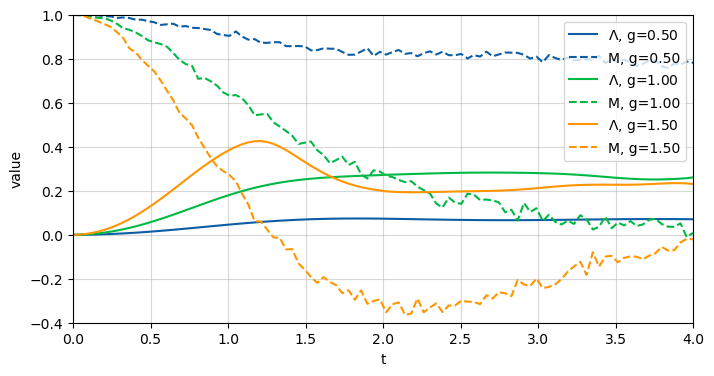

In [135]:
fig, ax_a = plt.subplots(1, 1, figsize=(8,4))
colors = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
# custom_cycler =  (cycler('color', ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']) ) #+ cycler('ls', ['-', '--', '-.', ':', '-', '--', ':'])
# ax_a.set_prop_cycle(custom_cycler)


for i, g in enumerate(gs):
    ax_a.plot(ts, results_both[g][0], '-',color = colors[i],     label=rf'$\Lambda$, g={g:.2f}')
    ax_a.plot(ts, results_both[g][1], '--',color = colors[i],  label=rf'M, g={g:.2f}')
    
# ax_a.plot(ts, Ms_symm, '-', color="blue", label='Ising trot2')
# ax_a.plot(ts, magn_th, '--', color="black", label='Ising theor')
ax_a.grid(alpha=0.5)
ax_a.set_ylim((-0.4, 1.001))
ax_a.set_xlim((0, 4))
# ax_a.set_title(r'$\lambda$')
ax_a.set_xlabel("t")
ax_a.set_ylabel('value')
ax_a.legend(loc="best")

plt.savefig('./report/pics/lambda10.png',format='png', dpi=300,  bbox_inches='tight')
plt.show()

## Ex. 11

In [36]:
from qiskit.quantum_info import DensityMatrix, partial_trace

In [65]:
def TFIM_3(t, evolve_method, num_q=10, g = 1.0, n_shots=400, dt = 0.03):
    """
    dt -- time step
    w  -- external frequency
    w0 -- system frequency
    w1 -- driving field strength
    """
    # Create a new quantum circuit with one qubit
    qc = qiskit.QuantumCircuit(num_q)
    
    GSup = qiskit.QuantumCircuit(num_q)
    GSdown = qiskit.QuantumCircuit(num_q)
    for qubit in range(num_q):
        GSdown.x(qubit)


    # Time evolve the circuit
    # qc = evolve_basic(qc, t, dt, g)
    qc = evolve_method(qc, t, dt, g)


    # Get the statevector simulator backend
    statevector_simulator = Aer.get_backend('statevector_simulator')

    # Simulate the first circuit
    result1 = statevector_simulator.run(GSup).result()
    statevectorGSup = result1.get_statevector()

    result1 = statevector_simulator.run(GSdown).result()
    statevectorGSdown = result1.get_statevector()


    result1 = statevector_simulator.run(qc).result()
    STATEvector = result1.get_statevector()

    
    # l1 = np.abs(np.vdot(statevectorGSup, STATEvector))**2.0
    # l2 = np.abs(np.vdot(statevectorGSdown, STATEvector))**2.0
    # L = l1 + l2
    # # print(num_q)
    return STATEvector.to_operator().to_matrix()
    



In [66]:
def vN_entropy(rho):
    """ Compute the von Neumann entropy of a density matrix """
    eigenvalues = np.linalg.eigvalsh(rho)
    # Filter out small eigenvalues to avoid numerical issues
    eigenvalues = eigenvalues[eigenvalues > 1e-10]
    return -np.sum(eigenvalues * np.log(eigenvalues)).real

def renyi2_entropy(rho):
    """ Compute the second Rényi entropy of a density matrix """
    return -np.log(np.trace(rho @ rho)).real

In [67]:
num_qubits = 10
rho = TFIM_3(1, evolve_basic, num_q=num_qubits, g = 2.0, n_shots=400, dt = 0.003)
rho_right = partial_trace(rho, range(num_qubits // 2)).to_operator().to_matrix()
print(f"{vN_entropy(rho_right) = }")
print(f"{renyi2_entropy(rho_right) = }")

vN_entropy(rho_right) = 0.262400752107398
renyi2_entropy(rho_right) = 0.14611665318158792


In [68]:
def get_tfim_rho_entropy(t, entropy_func):
    num_qubits = 10
    rho = TFIM_3(t, evolve_basic, num_q=num_qubits, g = 2.0, n_shots=400, dt = 0.003)
    rho_right = partial_trace(rho, range(num_qubits // 2)).to_operator().to_matrix()
    return entropy_func(rho_right)

In [75]:
ts = np.linspace(0.8, 1.2, 10)
Ss1 = np.array([get_tfim_rho_entropy(t, vN_entropy) for t in ts])
Ss2 = np.array([get_tfim_rho_entropy(t, renyi2_entropy) for t in ts])

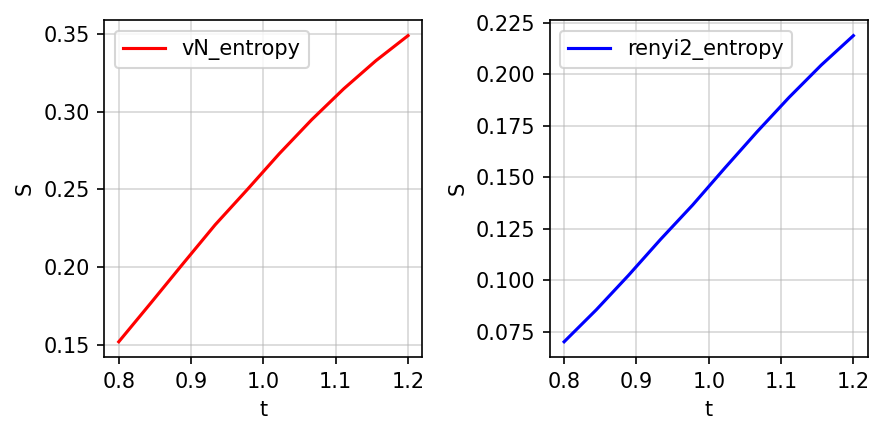

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3), dpi=150)
ax1.plot(ts, Ss1, color="red", label="vN_entropy")
ax2.plot(ts, Ss2, color="blue", label="renyi2_entropy")

for ax in [ax1, ax2]:
    ax.set_xlabel("t")
    ax.set_ylabel("S")
    ax.grid(alpha=0.5)
    ax.legend()
plt.tight_layout()
plt.savefig("ex11.png")
plt.show()

## Ex. 13

In [77]:
# import qiskit
# from qiskit import QuantumCircuit, execute, Aer
from qiskit.quantum_info import random_unitary
# import numpy as np

In [113]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer  import Aer
from qiskit_aer import AerSimulator
from qiskit.quantum_info import random_unitary

In [114]:
def TFIM_4(t, evolve_method, num_q=10, g=1.0, dt=0.03):
    """
    Simulate the transverse field Ising model using a given evolution method.
    
    Args:
    - t (float): Total time of the evolution.
    - evolve_method (function): The evolution function to be applied to the circuit.
    - num_q (int): Number of qubits.
    - g (float): Coupling constant of the Ising model.
    - dt (float): Time step for the evolution.

    Returns:
    - numpy.ndarray: The statevector of the system at time t.
    """
    # Initialize the quantum circuit for num_q qubits
    qc = qiskit.QuantumCircuit(num_q)

    # Apply the time evolution specified by the evolve_method
    qc = evolve_method(qc, t, dt, g)

    # Get the statevector simulator backend
    statevector_simulator = Aer.get_backend('statevector_simulator')

    # Simulate the quantum circuit to get the final statevector
    result = statevector_simulator.run(qc).result()
    statevector = result.get_statevector(qc)

    return statevector

In [165]:
# def hamming(s1, s2):
#     """Calculate the Hamming distance between two bitstrings"""
#     assert len(s1) == len(s2), "Bitstrings must be of the same length"
#     return sum(c1 != c2 for c1, c2 in zip(s1, s2))

# def apply_random_unitaries(qc, num_qubits):
#     """Apply a random unitary from the CUE to each qubit in the circuit"""
#     for q in range(num_qubits):
#         U = random_unitary(2).data
#         qc.unitary(U, [q], label='U{}'.format(q))


# def simulate_probabilities(t, evolve_method, num_q=10, g=1.0, dt=0.03, n_shots=1000):
#     """
#     Simulate the quantum circuit and return the probabilities of outcomes.
    
#     Args:
#     - t (float): Total time of the evolution.
#     - evolve_method (function): The time evolution method to apply.
#     - num_q (int): Number of qubits.
#     - g (float): Coupling constant.
#     - dt (float): Time step for the evolution.
#     - n_shots (int): Number of shots to use for the measurement.
    
#     Returns:
#     - dict: Probabilities of each outcome.
#     """
#     qc = qiskit.QuantumCircuit(num_q)
#     qc = evolve_method(qc, t, dt, g)
#     qc.measure_all()
    
#     # Setup the simulator
#     backend = Aer.get_backend('qasm_simulator')
#     transpiled_circuit = qiskit.transpile(qc, backend)
#     job = backend.run(transpiled_circuit, shots=n_shots)
#     result = job.result()
#     counts = result.get_counts()

#     return {k: v / n_shots for k, v in counts.items()}

# def compute_S2(probabilities, num_qubits):
#     """Compute the second Rényi entropy based on measurement probabilities"""
#     terms = []
#     for sA in probabilities:
#         for sA_prime in probabilities:
#             if sA != sA_prime:
#                 hamming_dist = hamming(sA, sA_prime)
#                 term = ((-2)**(-hamming_dist)) * probabilities[sA] * probabilities[sA_prime]
#                 terms.append(term)
#     X = 2**(num_qubits) * sum(terms)
#     return -np.log(np.abs(X)+1e-15)

In [164]:
# def apply_random_unitaries(circuit, num_qubits):
#     """Applies random unitaries to each qubit in the circuit."""
#     for q in range(num_qubits):
#         u = random_unitary(2).data
#         circuit.unitary(u, [q], label='random_u')
#     return circuit

# def simulate_subsystem_circuit(circuit, num_qubits, subsystem_qubits, shots=2000):
#     """Simulates the circuit focusing only on the subsystem defined by subsystem_qubits."""
#     measure_circuit = QuantumCircuit(num_qubits, len(subsystem_qubits))  # Adding classical bits
#     for i, q in enumerate(subsystem_qubits):
#         measure_circuit.measure(q, i)  # Measure quantum bit 'q' into classical bit 'i'
#     full_circuit = circuit.compose(measure_circuit)
    
#     simulator = AerSimulator()
#     job = simulator.run(full_circuit, shots=shots)
#     result = job.result()
#     counts = result.get_counts(full_circuit)
#     return counts

# def calculate_s2(counts, shots):
#     """Calculates the second Rényi entropy based on the measurement outcomes."""
#     probabilities = np.array(list(counts.values())) / shots
#     return -np.log2(np.sum(probabilities**2))

# def main(num_qubits, g, timesteps, subsystem_qubits, statevector, shots=2000):
#     """Main function to prepare the circuit, apply random unitaries, simulate, and compute S(2)."""
#     # initial_state = [1] + [0] * (2**num_qubits - 1)  # Example initial state

#     circuit = QuantumCircuit(num_qubits)
#     circuit.initialize(statevector, range(num_qubits))
#     apply_random_unitaries(circuit, num_qubits)
#     counts = simulate_subsystem_circuit(circuit, num_qubits, subsystem_qubits, shots)
#     s2 = calculate_s2(counts, shots)

#     print(f"Second Rényi Entropy S(2) for subsystem: {s2}")

In [163]:
# t = 1.0

# # Example usage
# num_qubits = 10
# subsystem_qubits = [0, 1, 2, 3, 4]  # Define which qubits are in the subsystem
# g = 2  # Example parameter, not used directly in this snippet
# # timesteps = 5  # Example parameter, not used directly in this snippet
# statevector = TFIM_4(t, evolve_basic, num_q=10, g=1.0, dt=0.03)

# main(num_qubits, g, timesteps, subsystem_qubits, statevector, 2000)

In [170]:

def hamming_distance(s1, s2):
    """Calculate the Hamming distance between two bitstrings."""
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def apply_random_unitaries_and_measure(circuit, num_qubits, subsystem_qubits, num_unitaries=200, shots=2000):
    """Applies random unitaries, measures the circuit, and calculates probabilities."""
    simulator = AerSimulator()
    results = []

    for _ in range(num_unitaries):
        temp_circuit = circuit.copy()
        for q in subsystem_qubits:
            u = random_unitary(2).data
            temp_circuit.unitary(u, [q], label=f'random_u_{q}')
        temp_circuit.measure(subsystem_qubits, list(range(len(subsystem_qubits))))

        job = simulator.run(temp_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(temp_circuit)
        results.append(counts)

    return results

def calculate_s2(results, shots):
    """Calculate the second Rényi entropy using the results of different random unitaries."""
    # Initialize the dictionary to store overall probabilities
    prob_dict = {}
    for counts in results:
        for bitstring, count in counts.items():
            if bitstring not in prob_dict:
                prob_dict[bitstring] = 0
            prob_dict[bitstring] += count / shots
    
    # Normalize the probabilities
    total = sum(prob_dict.values())
    for bitstring in prob_dict:
        prob_dict[bitstring] /= total
    
    # Calculate X_bar for S(2)
    X_bar = 0
    keys = list(prob_dict.keys())
    for i in range(len(keys)):
        for j in range(len(keys)):
            ham_dist = hamming_distance(keys[i], keys[j])
            X_bar += 2**(-ham_dist) * prob_dict[keys[i]] * prob_dict[keys[j]]

    return -np.log2(X_bar)

def main(num_qubits, subsystem_qubits, statevector, num_unitaries=200, shots=2000):
    """Main function to prepare the circuit, apply random unitaries, measure, and compute S(2)."""
    circuit = QuantumCircuit(num_qubits, len(subsystem_qubits))
    circuit.initialize(statevector, range(num_qubits))
    # Example initial state preparation if needed
    # circuit.x(subsystem_qubits)  # for demonstration, preparing an excited state

    results = apply_random_unitaries_and_measure(circuit, num_qubits, subsystem_qubits, num_unitaries, shots)
    s2 = calculate_s2(results, shots)

    print(f"Second Rényi Entropy S(2) for subsystem: {s2}")

# Example usage
num_qubits = 10
subsystem_qubits = [0, 1, 2, 3, 4]  # Define which qubits are in the subsystem
statevector = TFIM_4(0.1, evolve_basic, num_q=10, g=2.0, dt=0.03)
main(num_qubits, subsystem_qubits, statevector)

Second Rényi Entropy S(2) for subsystem: 2.0695490600927635
